In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Transform csv file into dataframe
data = pd.read_csv("DataCoSupplyChainDataset.csv")

# Display first few rows of the dataframe
print(data.head())

       Type  Days for shipping (real)  Days for shipment (scheduled)  \
0     DEBIT                         3                              4   
1  TRANSFER                         5                              4   
2      CASH                         4                              4   
3     DEBIT                         3                              4   
4   PAYMENT                         2                              4   

   Benefit per order  Sales per customer   Delivery Status  \
0          91.250000          314.640015  Advance shipping   
1        -249.089996          311.359985     Late delivery   
2        -247.779999          309.720001  Shipping on time   
3          22.860001          304.809998  Advance shipping   
4         134.210007          298.250000  Advance shipping   

   Late_delivery_risk  Category Id   Category Name Customer City  ...  \
0                   0           73  Sporting Goods        Caguas  ...   
1                   1           73  Sporting Goo

In [3]:
# Check information of each column
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

In [4]:
# Unify column name
data.rename(columns={"order date (DateOrders)": "Order date",
                     "shipping date (DateOrders)":"Shipping date",
                     "Late_delivery_risk":"Late delivery risk"}, inplace=True)

In [5]:
# Convert "Order date" and "Shipping data" to datetime format
data["Order date"] = pd.to_datetime(data["Order date"])
data["Shipping date"] = pd.to_datetime(data["Shipping date"])

## Calculationg the Perfect Order Rate (POR) helps assess how efficiently and accurately orders are fulfilled, ensuring they meet delivery, completeness and quality standards. 

### To calculate the POR, the first step is to calculate the On-Time Delivery(OTD). 

In [6]:
# Find out the number of complete orders
complete_order = data[data["Order Status"] == "COMPLETE"]
num_complete_orders = complete_order["Order Status"].value_counts()

# Find out the number of complete orders that delivered on time
on_time_complete = complete_order[complete_order["Days for shipping (real)"] <= complete_order["Days for shipment (scheduled)"]]
num_on_time_complete = on_time_complete["Order Status"].value_counts()

# On-Time Delivery Ratio
otd = num_on_time_complete / num_complete_orders
print(otd)

COMPLETE    0.42514
Name: Order Status, dtype: float64


### Next is to find out the complete order rate. Means no missing or incorrect items.

In [7]:
# Find out the number of complete orders
complete_order = data[data["Order Status"] == "COMPLETE"]
num_complete_orders = complete_order["Order Status"].value_counts()

# Calculate the total orders
total_order = data["Order Status"].count()

# Complete orders
complete_order_rate = num_complete_orders / total_order
print(complete_order_rate)

COMPLETE    0.329555
Name: Order Status, dtype: float64


### Use the data we got for now to calculate the Perfect Order Rate (POR)

In [8]:
por = otd * complete_order_rate
print(por)

COMPLETE    0.140107
Name: Order Status, dtype: float64


## DataCo Global currently has an On-Time Delivery (OTD) rate of 43%, a Complete Order Rate of 33%, and a Perfect Order Rate (POR) of 14%. These figures indicate significant inefficiencies in the fulfillment process. To enhance performance, the company must focus on improving delivery speed, order accuracy, and overall fulfillment reliability.

### Next is to calculate the Order Cycle Time(OCT)

In [9]:
# Find out the complete orders
complete_order = data[data["Order Status"] == "COMPLETE"]

# Calculate the total time from order placement to final delivery
days_spent = (complete_order["Shipping date"] - complete_order["Order date"]).dt.days
avg_days_spent = days_spent.mean()
print(avg_days_spent)

3.4631456859020693


### Analyze the order status

In [10]:
# Get the total orders
total_orders = data["Order Status"].value_counts().reset_index().rename(columns={'index': 'Order Status', 'Order Status': 'Count'})
total_orders["Proportion"] = round(total_orders["Count"] / data["Order Status"].count(), 2)
# Save total_orders into csv file
total_orders.to_csv("Total Orders.csv", index=False)
print(total_orders)

      Order Status  Count  Proportion
0         COMPLETE  59491        0.33
1  PENDING_PAYMENT  39832        0.22
2       PROCESSING  21902        0.12
3          PENDING  20227        0.11
4           CLOSED  19616        0.11
5          ON_HOLD   9804        0.05
6  SUSPECTED_FRAUD   4062        0.02
7         CANCELED   3692        0.02
8   PAYMENT_REVIEW   1893        0.01


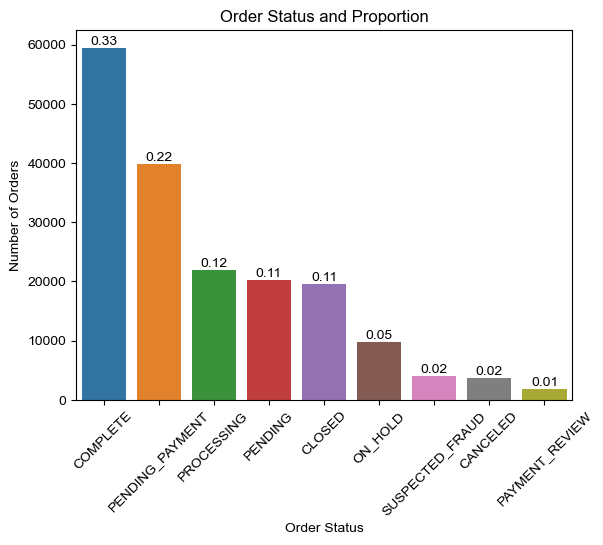

In [11]:
plot = sns.barplot(data=total_orders, x="Order Status", y="Count")
plt.xticks(rotation=45)
plot.bar_label(plot.containers[0], labels=total_orders["Proportion"])
plot.set_ylabel("Number of Orders")
sns.set_style("darkgrid")
plt.title("Order Status and Proportion")
plt.show()

## Cost Metrics

### Total Supply Chain Cost (% of revenue)

In [12]:
# Join DataCo Cost Table
cost = pd.read_csv("Cost.csv")
merged = data.merge(cost, how="left", left_on="Order Id", right_on="Order ID")

In [13]:
# Total Supply Chain Cost% = total fulfillment cost / revenue * 100
total_supply_chain_cost = round(merged["Total Fulfillment Cost ($)"].sum() / merged["Revenue ($)"].sum() * 100, 2)
print(f"Total Supply Chain Cost is: {total_supply_chain_cost}%")

Total Supply Chain Cost is: 15.81%


### Cost per Order

In [18]:
# Average Cost per Order: Total fulfillment cost / number of orders
avg_cost_per_order = round(merged["Total Fulfillment Cost ($)"].sum() / merged["Order ID"].count(), 2)
print(f"Average cost per order is: ${avg_cost_per_order}")

# Average Order Price
avg_order_price =round(merged["Order Item Total"].sum() / merged["Order Item Total"].count(), 2)
print(f"Average order price is: ${avg_order_price}")

Average cost per order is: $43.5
Average order price is: $183.11


### Freight Cost per Unit

In [15]:
# Freight Cost per Unit: shipping cost / total unit shipped
freight_cost_per_unit = merged["Shipping Cost ($)"] / merged.groupby("Order Id")["Order Item Quantity"].sum()
print(freight_cost_per_unit.dropna().mean())

10.087042079231066
